In [7]:
#!/usr/bin/env python3
"""Visualization script for Go1 with height scanner."""
import os
# Tell XLA to use Triton GEMM
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
os.environ['MUJOCO_GL'] = 'egl'

import jax
import jax.numpy as jp
import numpy as np
import mujoco
import cv2
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPyimage, display
from custom_env import Joystick, default_config
from io import BytesIO

Creating Visualization...
Running simulation...
Creating GIF 1/1

Reset 1 - Wall positions:
  Wall 0: geom_xpos[z]=0.281
  Wall 1: geom_xpos[z]=0.343
  Wall 2: geom_xpos[z]=0.289
  Wall 3: geom_xpos[z]=0.347
  Wall 4: geom_xpos[z]=0.284
  Wall 5: geom_xpos[z]=0.251

    Rendering 50 frames...


100%|██████████| 50/50 [00:00<00:00, 77.47it/s]


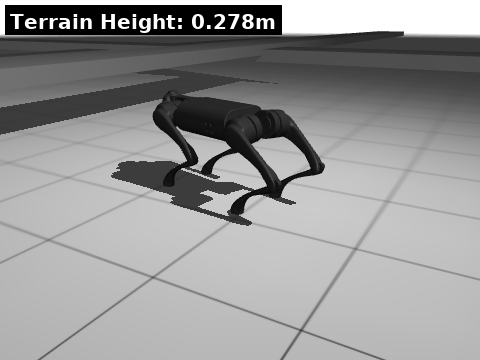

✓ All 1 GIFs created successfully!


In [8]:

# Set up visualization options
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True   # Show visual geoms
scene_option.geomgroup[3] = False  # Hide collision geoms
scene_option.geomgroup[5] = True   # Show sites (including height scanner visualization)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # Show contact points
scene_option.flags[mujoco.mjtVisFlag.mjVIS_RANGEFINDER] = True
print("Creating Visualization...")

# We will no longer use the registry, but directly load our custom XML and model.
# We will load the "debug" version here, which adds an additional wall *under* the robot
# We add this to understand that changing walls correctly affects collision + raycasting.
xml_path = 'custom_env.xml' # 'custom_env_debug_wall.xml'
env = Joystick(xml_path=xml_path, config=default_config())

# NOTE: For this test, we manually set init_q z position high to avoid collisions with walls 
# env._init_q = env._init_q.at[2].set(1.0)

# JIT compile the functions for speed
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_terrain_height = jax.jit(env._get_torso_terrain_height)

# Initialize
key = jax.random.PRNGKey(15)

print("Running simulation...")

# Perform multiple random resets to show different wall configurations
num_resets = 1
steps_per_reset = 50  # More steps to show movement

for reset_idx in range(num_resets):
    print(f"Creating GIF {reset_idx+1}/{num_resets}")

    # Randomize wall heights for this reset
    # set_wall_heights(env, range_min=0.05, range_max=0.4)

    # Generate new random key for this reset
    key, reset_key = jax.random.split(key)

    # Reset to new random position
    state = jit_reset(reset_key)

    # Collect frames and terrain heights for this reset
    rollout = []
    terrain_heights = []

    for step in range(steps_per_reset):
        rollout.append(state)

        # Calculate terrain height for this state
        terrain_height = jit_terrain_height(state.data)
        terrain_heights.append(float(terrain_height))

        # Check for NaN/inf in reward
        if not jp.isfinite(state.reward):
            print(f"    WARNING: Non-finite reward detected!")
            print(f"    Reward value: {state.reward}")
            raise ValueError("Non-finite reward encountered during simulation")

        # Use small random actions to show some movement
        action_key, key = jax.random.split(key)
        action = jax.random.normal(action_key, (env.action_size,)) * 0.1
        state = jit_step(state, action)

    # Debug prints: check wall positions from simulation data
    current_data = rollout[-1].data  # Get the latest state
    print(f"\nReset {reset_idx+1} - Wall positions:")
    for i, wall_geom_id in enumerate(env._wall_geom_ids):
        wall_pos = current_data.geom_xpos[wall_geom_id]
        print(f"  Wall {i}: geom_xpos[z]={wall_pos[2]:.3f}")
    print()

    # Render frames for this reset
    print(f"    Rendering {len(rollout)} frames...")

    frames = env.render(
        rollout,
        camera="track",  # Use tracking camera
        scene_option=scene_option,
        width=480,
        height=360,
    )

    # # Create GIF for this reset
    # gif_filename = f'wall_randomization_{reset_idx+1:02d}.gif'
    # print(f"    Saving GIF to {gif_filename}...")

    # # Convert frames to PIL Images and add terrain height overlay
    # pil_images = []
    # for i, frame in enumerate(frames):
    #     pil_image = Image.fromarray(frame)

    #     # Add terrain height overlay
    #     draw = ImageDraw.Draw(pil_image)
    #     terrain_height_text = f"Terrain Height: {terrain_heights[i]:.3f}m"

    #     # Try to use a default font, fallback to default if not available
    #     try:
    #         font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
    #     except:
    #         font = ImageFont.load_default()

    #     # Draw background rectangle for better text visibility
    #     text_bbox = draw.textbbox((0, 0), terrain_height_text, font=font)
    #     text_width = text_bbox[2] - text_bbox[0]
    #     text_height = text_bbox[3] - text_bbox[1]

    #     # Position text in top-left corner with padding
    #     x, y = 10, 10
    #     draw.rectangle([x-5, y-5, x+text_width+5, y+text_height+5], fill=(0, 0, 0, 128))
    #     draw.text((x, y), terrain_height_text, fill=(255, 255, 255), font=font)

    #     pil_images.append(pil_image)
    pil_images = []
    for i, frame in enumerate(frames):
        pil_image = Image.fromarray(frame)

        # Add terrain height overlay
        draw = ImageDraw.Draw(pil_image)
        terrain_height_text = f"Terrain Height: {terrain_heights[i]:.3f}m"

        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = ImageFont.load_default()

        text_bbox = draw.textbbox((0, 0), terrain_height_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        x, y = 10, 10
        draw.rectangle([x-5, y-5, x+text_width+5, y+text_height+5], fill=(0, 0, 0, 128))
        draw.text((x, y), terrain_height_text, fill=(255, 255, 255), font=font)

        pil_images.append(pil_image)

    # Display GIF inline without saving
    buf = BytesIO()
    pil_images[0].save(
        buf,
        format="GIF",
        save_all=True,
        append_images=pil_images[1:],
        duration=80,   # ms per frame
        loop=0
    )
    buf.seek(0)
    display(IPyimage(data=buf.getvalue()))
    

print(f"✓ All {num_resets} GIFs created successfully!")


In [ ]:
from custom_env import default_config